In [1]:
# Efflux / Reflux (Cokelet & Stewart, 1985)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Find the interface and vertical flux of theta
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    Xu = uzx.shape[1]
    itf = np.empty(Xu, dtype=int)
    itf[[0,1]] = 0 # Remove data at fjord head and end
    for i in range(2,Xu):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [8]:
def FluxCoef(state, grid):
    state1 = state.isel(X=range(120), Y=range(30,39), Xp1=range(121),T=range(275,337))
    grid1 = grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))
    u = state1.U.data
    w = state1.W.data
    sal = state1.S.data.mean(axis=(0,2))
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600
    
    # f=48, s=72 for slope region
    f = 2
    s = 70
    HFacW = grid1.HFacW.data[:,:,f:s+1] # vertical fraction of open cell at West face
    HFacC = grid1.HFacC.data[:,:,f:s+1].mean(1) # vertical fraction of open cell at cell center
    drF = grid1.drF.data # r cell face separation
    rA = grid1.rA.data[:,f:s+1] # r face area at cell center
    itf = Layer(u)
    it = itf[f:s+1]
    
    ut = u[:,:,:,f:s+1].mean(0)
    uzx = u[:,:,:,f:s+1].mean(axis=(0,2))
    wt = w[:,:,:,f:s+1].mean(0)
    S = sal[:,f:s+1]      
    rA = grid1.rA.data[:,f:s+1] # r face area at cell center
    itf = Layer(u)
    it = itf[f:s+1]
    Vx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    Vz = np.empty(s-f+1) # Vertical volume transport through the interface
    h1 = np.empty(s-f+1)
    h2 = np.empty(s-f+1)
    Ux1 = np.empty(s-f+1)
    Ux2 = np.empty(s-f+1)
    Sx1 = np.empty(s-f+1)
    Sx2 = np.empty(s-f+1)
    
    for i in range(s-f+1):
        
        #gh = drF * HFacC[:,i] # grid height  
        gh = drF * HFacW[:,:,i].mean(1) # grid height 
        h1[i] = gh[:it[i]].sum()    
        h2[i] = gh[it[i]:].sum()
        
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
        
        Ux1[i] = Vx1[i] / np.sum(HFacW[:it[i],:,i] * Area[:it[i],:])
        Ux2[i] = Vx2[i] / np.sum(HFacW[it[i]:,:,i] * Area[it[i]:,:])
        #Ux2[i] = np.sum(uzx[it[i]:,i] * gh[it[i]:]) / h2[i]
        
        Sx1[i] = np.sum(S[:it[i],i] * gh[:it[i]]) / h1[i]
        Sx2[i] = np.sum(S[it[i]:,i] * gh[it[i]:]) / h2[i]
     
    Q1 = -Vx2[-1]
    Q2 = Vx1[-1]
    Q3 = -Vx2[0]
    Q4 = Vx1[0]
    
    S1 = Sx2[-1]
    S2 = Sx1[-1]
    S3 = Sx2[0]
    S4 = Sx1[0]
    
    U1 = -Ux2[-1]
    U2 = Ux1[-1]
    U3 = -Ux2[0]
    U4 = Ux1[0]
    
    H1 = h2[-1]
    H2 = h1[-1]
    H3 = h2[0]
    H4 = h1[0]
    
    alph34 = (Q3-Q1)/Q4
    alph24 = Q2 / Q4
    Qr = Q4 - Q2
    Qe = 0.5 * Q4 + 0.5 * Q1
    R_f = Q4 / 700
    return (U1, U4, H2, H4, S2, alph24)

In [11]:
hs = np.array([9,12,15,18]) # Sill depth
h = 150
hsr = hs / h
beta = 7e-4 # Saline contractoin coef
g = 9.81
B = 1800 # Fjord width
Qf = 700
uf = Qf / (B*h)

u1 = np.empty(len(hs))
u4 = np.empty(len(hs))
h2 = np.empty(len(hs))
h4 = np.empty(len(hs))
s2 = np.empty(len(hs))
a24 = np.empty(len(hs))
for i in range(len(hs)):
    State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/state_' + str(format(hs[i],'03d')) + '.nc')
    Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/grid_' + str(format(hs[i],'03d')) + '.nc')
    
    u1[i], u4[i], h2[i], h4[i], s2[i], a24[i] = FluxCoef(State, Grid)

#ue = (Qf*beta*g*s1/B)**(1/3) # Hydraulic Controlled velocity
u1hc = (Qf*beta*g*s2/B)**(1/3) # Hydraulic Controlled velocity
u2a = (Qf/(B*hs))**(1/3)
u4a = np.ones(len(hs)) * (uf**(1/3))
#(beta*g*30*h)**(1/3)
#uf**(1/3), u4

Text(0.5, 0, '$h_s/h$')

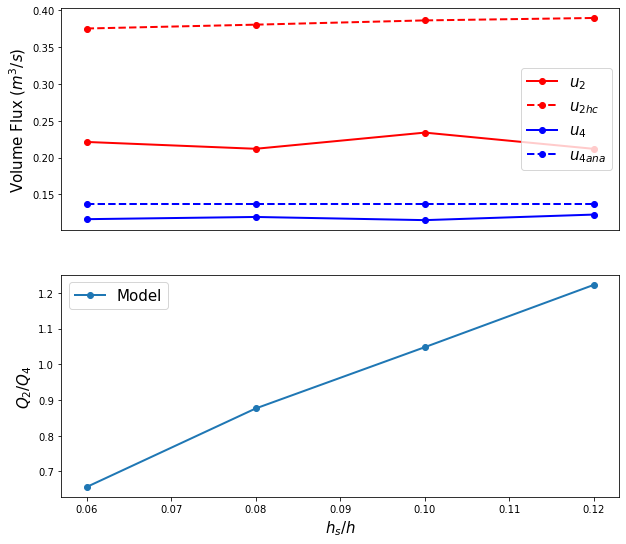

In [12]:
fig0 = plt.figure(figsize=(10,9))
fig0.tight_layout()

ax1 = fig0.add_subplot(211)


plt.ylabel(r'Volume Flux $(m^3/s)$', size=15)
ax1.plot(hsr, u1, 'o-r', lw=2, label=r'$u_2$')
ax1.plot(hsr, u1hc, 'o--r', lw=2, label=r'$u_{2hc}$')
ax1.plot(hsr, u4, 'o-b', lw=2, label=r'$u_4$')
#ax.axhline(y=uf**(1/3), lw=2, label=r'$u_{ana}$')
ax1.plot(hsr, u4a, 'o--b', lw=2, label=r'$u_{4ana}$')
ax1.legend(loc = 'right', fontsize=15)
ax1.axes.get_xaxis().set_visible(False)




#ax2 = fig0.add_subplot(312)
#plt.ylabel(r'Depth Ratio', size=15)
#ax2.plot(hsr, h2/h4, 'o-', lw=2, label=r'$h_2/h_4$')
#ax2.legend(loc = 'best', fontsize=15)
#ax2.axes.get_xaxis().set_visible(False)



ax2 = fig0.add_subplot(212)
plt.ylabel(r'$Q_2/Q_4$', size=15)
ax2.plot(hsr, a24, 'o-', lw=2, label=r'Model')
#ax2.plot(hsr, (ue*hs/2)/(u4a*h4), 'o-', lw=2, label=r'Estimate')
ax2.legend(loc = 'best', fontsize=15)
plt.xlabel(r'$h_s/h$', size=15)

#(h2/h4) / hsr

def LayerSalinity(state, grid):
    state1 = state.isel(Y=range(30,39), T=range(24,161))       
    u = state1.U.data
    
    salinity = state1.S.data
    
    gh = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) # Grid height

    f = 55
    s = 72
    uzx = u[:,:,:,f:s+1].mean(axis=(0,2))
    #itf = Layer(u)
    Sx1 = np.empty(s-f+1) # Horizontal volume transport for the upper layer
    Sx2 = np.empty(s-f+1) # Horizontal volume transport for the lower layer
    for i in range(s-f+1):
        #it = itf[f:s+1]
        p = np.where(uzx[:,i] < 0)[-1][0]
        h1 = gh[:p].sum()
        Szx = salinity[:,:,:,f:s+1].mean(axis=(0,2))
        Sx1[i] = np.sum(Szx[:p,i] * gh[:p]) / h1
        
        if sum(j < 0 for j in uzx[p:,i]) == len(gh)-p:
            n = len(gh) - p
        else:    
            n = np.where(uzx[p:,i] >= 0)[-1][0]
            
        h2 = gh[p:p+n].sum()
        Sx2[i] = np.sum(Szx[p:p+n,i] * gh[p:p+n]) / h2
        
        
        #Sx1[i] = np.sum(St[:it[i],i] * gh[:it[i]] ) / np.sum(gh[:it[i]])
        #Sx2[i] = np.sum(St[it[i]:,i] * gh[it[i]:] ) / np.sum(gh[it[i]:])
     
    S1 = Sx2[-1]
    S2 = Sx1[-1]
    S3 = Sx2[0]
    S4 = Sx1[0]
    
    # mixing factors
    Poc = S1 / (S1 - S2)
    Pfj = S3 / (S3 - S4)
    
    return (Poc, Pfj)

In [ ]:
f = np.poly1d([5, 1])
x = np.linspace(0, 10, 30)
a = np.vstack([x, np.ones(len(x))]).T
y = f(x) + 6*np.random.normal(size=len(x))
np.linalg.lstsq(a, y,rcond=None)[0]

In [ ]:
hs = np.array([9,12,15,18]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
hsr = hs / 150

Poc_1 = np.empty(len(hs))
Pfj_1 = np.empty(len(hs))


for j in range(len(hs)):
    #/Volumes/Extreme SSD/MITgcm outputs/
    #/Users/weiyangbao/Documents/Model_outputs/
    state01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf350/state_' + str(format(hs[j],'03d')) + '.nc')
    grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf350/grid_' + str(format(hs[j],'03d')) + '.nc')
    
    Poc, Pfj = LayerSalinity(state01,grid01)
    Poc_1[j] = Poc
    Pfj_1[j] = Pfj
    
Poc_1 / hs,  Pfj_1

In [ ]:

hs = np.array([9, 12, 15, 18]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
#hs2 = np.array([9, 12])
hsr = hs / 150

#a24 = np.empty(len(hs))
a34_1 = np.empty(len(hs))
Qr_1 = np.empty(len(hs))
#Q3e = np.empty(len(hs))
a34_2 = np.empty(len(hs))
Qr_2 = np.empty(len(hs))

a34_3 = np.empty(len(hs))
Qr_3 = np.empty(len(hs))

a34_4 = np.empty(len(hs))
Qr_4 = np.empty(len(hs))

for j in range(len(hs)):
    #/Volumes/Extreme SSD/MITgcm outputs/
    #/Users/weiyangbao/Documents/Model_outputs/
    state01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag000/state_' + str(format(hs[j],'03d')) + '.nc')
    grid01 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag000/grid_' + str(format(hs[j],'03d')) + '.nc')

    state02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag125/state_' + str(format(hs[j],'03d')) + '.nc')
    grid02 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag125/grid_' + str(format(hs[j],'03d')) + '.nc') 

    state03 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/state_' + str(format(hs[j],'03d')) + '.nc')
    grid03 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_rot/grid_' + str(format(hs[j],'03d')) + '.nc')

    state04 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag025/state_' + str(format(hs[j],'03d')) + '.nc')
    grid04 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf700_drag025/grid_' + str(format(hs[j],'03d')) + '.nc')
    
    
    alph1, q1 = FluxCoef(state01,grid01)
    a34_1[j] = alph1
    Qr_1[j] = q1

    alph2, q2 = FluxCoef(state02,grid02)
    a34_2[j] = alph2
    Qr_2[j] = q2
    
    alph3, q3 = FluxCoef(state03,grid03)
    a34_3[j] = alph3
    Qr_3[j] = q3
    
    alph4, q4 = FluxCoef(state04,grid04)
    a34_4[j] = alph4
    Qr_4[j] = q4
    

In [ ]:
xx = [1, 2, 3, 4]
fig, ax = plt.subplots(figsize=(12,6))



ax.plot(xx,Qr_3,'o-r',label=r'$\it{Q_r}$')
ax.plot(xx,150/hs,'o-b',label=r'$\it{h/hs}$')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc='center left', fontsize=18)
#ax.set_ylabel(r'Linear Coeffcient',size = 18)
#ax.set_xlabel(r'Tidal Amplitude $U_0$ (m/s)', size = 18)
#ax.set_ylim([-7.7, 1.3])
ax.grid(linestyle='--', linewidth='0.5')

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

ax1.plot(hsr,a34_1,'o-',label='0.00')
ax1.plot(hsr,a34_2,'o-',label='0.00125')
ax1.plot(hsr,a34_3,'o-',label='0.0025')
ax1.plot(hsr,a34_4,'o-',label='0.025')
ax1.legend(loc='best', fontsize=12, title=r'$C_d$')
ax1.set_ylabel(r'Reflux Coeffcient $\alpha_{34}$',size = 15)
ax1.set_xlabel(r'$h_s/h$', size = 15)
ax1.set_ylim([.1, .7])
ax1.grid(linestyle='--', linewidth='0.5')

ax2.plot(hsr,Qr_1,'o-')
ax2.plot(hsr,Qr_2,'o-')
ax2.plot(hsr,Qr_3,'o-')
ax2.plot(hsr,Qr_4,'o-')
ax2.set_ylabel(r'Reflux $(m^3/s)$',size = 15)
ax2.set_xlabel(r'$h_s/h$', size = 15)
ax2.grid(linestyle='--', linewidth='0.5')

#a34_1
fig1.savefig(fig_path + '/alpha34_Drag.png', dpi=200, bbox_inches='tight')
a34_1, a34_2, a34_3, a34_4

In [ ]:
tides = [0.00, 0.03, 0.06, 0.10]

a34 = [a34_1, a34_2, a34_3, a34_4]

Qr = [Qr_1, Qr_2, Qr_3, Qr_4]
#tides = [0.00, 0.10]

#a34 = [a34_1, a34_3]

k = np.empty(len(tides))
b = np.empty(len(tides))
for i in range(len(tides)):
    coef = np.linalg.lstsq(np.vstack([hsr, np.ones(len(hsr))]).T, Qr[i], rcond=None)[0]
    k[i] = coef[0]
    b[i] = coef[1]

fig2, ax = plt.subplots(figsize=(12,6))

ax.plot(tides,k,'o-r',label=r'$\it{k}$')
ax.plot(tides,b,'o-b',label=r'$\it{b}$')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc='center left', fontsize=18)
ax.set_ylabel(r'Linear Coeffcient',size = 18)
ax.set_xlabel(r'Tidal Amplitude $U_0$ (m/s)', size = 18)
ax.set_ylim([-7.7, 1.3])
ax.grid(linestyle='--', linewidth='0.5')
k, b
#fig2.savefig(fig_path + '/lstsq.png', dpi = 200, bbox_inches='tight')

In [ ]:
def IFA(file):
    # Grid areas
    Area = np.empty([50, 9])
    Area[:10,:] = 100
    Area[10:20,:] = 200
    Area[20:30,:] = 300
    Area[30:40,:] = 800
    Area[40:,:] = 1600
    t0 = 24
    tn = 161
    state = file.isel(Y=range(30,39), T=range(t0,tn))
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [ ]:
Qsm1 = np.empty(len(hs))
Qsm2 = np.empty(len(hs))
Qsm3 = np.empty(len(hs))
Qsm4 = np.empty(len(hs))

for j in range(len(hs)):
    file01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-only-hourly/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/qf-tide-hourly/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide006/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    file04 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/tide01/icefrntA_' + str(format(hs[j],'03d')) + '.nc')
    
    qsm1 = IFA(file01)
    Qsm1[j] = qsm1
    
    qsm2 = IFA(file02)
    Qsm2[j] = qsm2
    
    qsm3 = IFA(file03)
    Qsm3[j] = qsm3
    
    qsm4 = IFA(file04)
    Qsm4[j] = qsm4
    

fig3,ax = plt.subplots(figsize=(16,8))

ax.plot(hsr,Qsm1,'o-',label='0.00')
ax.plot(hsr,Qsm2,'o-',label='0.03')
ax.plot(hsr,Qsm3,'o-',label='0.06')
ax.plot(hsr,Qsm4,'o-',label='0.10')
ax.legend(loc='best', fontsize=15, title=r'$U_0(m/s)$')
ax.set_ylabel(r'Submarine melting $Q_{sm}(m^3/s)$',size = 20)
ax.set_xlabel(r'$h_s/h$', size = 20)
ax.grid(linestyle='--', linewidth='0.5')
fig2.savefig(fig_path + '/Qsm.png', dpi = 200, bbox_inches='tight')

In [ ]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig0.savefig(fig_path + '/Efflux.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/Mom_mag.png', dpi=200, bbox_inches='tight')